In [12]:
# import libraries
import pandas as pd
import numpy as np

from pandas.plotting import lag_plot
from pandas import concat

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
from sklearn.model_selection import train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

In [14]:
# importing dataset
df1 = pd.read_excel("./dataset/site1.xlsx")

In [15]:
# check the length of each dataset
len(df1)

70176

In [16]:
# Rename Columns
df1 = df1.rename(columns={
    'Time(year-month-day h:m:s)': 'Timestamp',
    'Wind speed at height of 10 meters (m/s)': 'WS_10',
    'Wind direction at height of 10 meters (˚)': 'WD_10',
    'Wind speed at height of 30 meters (m/s)': 'WS_30',
    'Wind direction at height of 30 meters (˚)': 'WD_30',
    'Wind speed at height of 50 meters (m/s)': 'WS_50',
    'Wind direction at height of 50 meters (˚)': 'WD_50',
    'Wind speed - at the height of wheel hub (m/s)': 'WS_hub',
    'Wind speed - at the height of wheel hub (˚)': 'WD_hub',
    'Air temperature  (°C) ': 'Air_T',
    'Atmosphere (hpa)': 'Air_P',
    'Relative humidity (%)': 'Air_H',
    'Power (MW)': 'Power'
})

In [17]:
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])

In [18]:
df1.set_index('Timestamp', inplace=True)

In [19]:
#print top values
df1.head()
# Frequency - 15 Seconds

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_hub,WD_hub,Air_T,Air_P,Air_H,Power
Timestamp,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005


In [20]:
# bottom values
df1.tail()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_hub,WD_hub,Air_T,Air_P,Air_H,Power
Timestamp,,,,,,,,,,,,
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250
2020-12-31 23:45:00,3.291,243.733,3.311,254.267,3.643,266.733,4.306,268.633,-8.991,889.492,53.381,12.384466


In [21]:
FEATURES_TO_USE = ['WS_10', 'WS_30', 'WS_50', 'WS_hub']

In [22]:
df_final = df1[FEATURES_TO_USE]
df_output = df1[['Power']]

In [23]:
df_final.head()

,WS_10,WS_30,WS_50,WS_hub
Timestamp,,,,
2019-01-01 00:00:00,2.209,1.991,2.094,2.494
2019-01-01 00:15:00,1.828,1.698,1.757,1.882
2019-01-01 00:30:00,2.193,2.313,2.344,2.350
2019-01-01 00:45:00,2.654,2.494,2.574,2.808
2019-01-01 01:00:00,2.249,2.192,2.558,2.924


/*------------------------ ADD LAGGED VALUES ---------------------*/

In [24]:
# Generate Lagged Values features
# data - actual wind data
# dataToLag - the output [Power]
# lag - number of lags to create
# return  - new dataframe with lagged values p-1, p-2, p-3 ...
def createLag(data, dataToLag, lag):
    
    data_lagged = []
    for i in range(1, lag+1):
        data_lagged.append(dataToLag.shift(i))

    dataframe = concat(data_lagged, axis=1).bfill()
    columns =  [f'P-{i}' for i in range(1, lag+1)]
    dataframe.columns = columns

    added_df = concat([data.reset_index(drop=True), dataframe.reset_index(drop=True)], axis=1)
    added_df.index = data.index
    return added_df


In [243]:
df_with_lag = createLag(df_final, df_output, 4)
df_with_lag.head()

,WS_10,WS_30,WS_50,WS_hub,P-1,P-2,P-3,P-4
Timestamp,,,,,,,,
2019-01-01 00:00:00,2.209,1.991,2.094,2.494,0.254383,0.254383,0.254383,0.254383
2019-01-01 00:15:00,1.828,1.698,1.757,1.882,0.254383,0.254383,0.254383,0.254383
2019-01-01 00:30:00,2.193,2.313,2.344,2.350,0.329703,0.254383,0.254383,0.254383
2019-01-01 00:45:00,2.654,2.494,2.574,2.808,0.296306,0.329703,0.254383,0.254383
2019-01-01 01:00:00,2.249,2.192,2.558,2.924,0.187590,0.296306,0.329703,0.254383


In [244]:
# lagged_df.head()
print("Total Dataset",df_with_lag.shape)

Total Dataset (70176, 8)


/*------------------------ DATA SPLITTING ---------------------*/

In [245]:
#select 70% of data
index_percent = int(len(df_with_lag) * 0.7)

/*------------------------ TRAINING DATA ---------------------*/

In [246]:
# Use 70% data for training
trainSetInput = df_with_lag[:index_percent]
trainSetOutput = df_output[: index_percent]

In [247]:
print("Input Train Size: "+ str(trainSetInput.shape), "\nOutput Train Size: "+ str(trainSetOutput.shape))
print(trainSetInput.head())

Input Train Size: (49123, 8) 
Output Train Size: (49123, 1)
                     WS_10  WS_30  WS_50  WS_hub       P-1       P-2  \
Timestamp                                                              
2019-01-01 00:00:00  2.209  1.991  2.094   2.494  0.254383  0.254383   
2019-01-01 00:15:00  1.828  1.698  1.757   1.882  0.254383  0.254383   
2019-01-01 00:30:00  2.193  2.313  2.344   2.350  0.329703  0.254383   
2019-01-01 00:45:00  2.654  2.494  2.574   2.808  0.296306  0.329703   
2019-01-01 01:00:00  2.249  2.192  2.558   2.924  0.187590  0.296306   

                          P-3       P-4  
Timestamp                                
2019-01-01 00:00:00  0.254383  0.254383  
2019-01-01 00:15:00  0.254383  0.254383  
2019-01-01 00:30:00  0.254383  0.254383  
2019-01-01 00:45:00  0.254383  0.254383  
2019-01-01 01:00:00  0.329703  0.254383  


/*------------------------ TEST DATA ---------------------*/

In [248]:
#Rest 30% for testing 
testSetInput = df_with_lag[index_percent:]
testSetOutput = df_output[index_percent:]

In [249]:
print("Input Test Size: "+ str(testSetInput.shape), "\nOutput Test Size: "+ str(testSetOutput.shape))
print(testSetInput.head())

Input Test Size: (21053, 8) 
Output Test Size: (21053, 1)
                     WS_10  WS_30  WS_50  WS_hub        P-1        P-2  \
Timestamp                                                                
2020-05-26 16:45:00  8.125  8.343  8.564   8.688  25.439707  24.755430   
2020-05-26 17:00:00  7.428  7.791  8.063   8.404  33.646040  25.439707   
2020-05-26 17:15:00  6.360  6.522  7.057   7.468  24.899677  33.646040   
2020-05-26 17:30:00  6.147  6.663  7.045   7.527  28.597466  24.899677   
2020-05-26 17:45:00  7.389  8.032  8.689   8.602  40.282024  28.597466   

                           P-3        P-4  
Timestamp                                  
2020-05-26 16:45:00  14.561643  16.923567  
2020-05-26 17:00:00  24.755430  14.561643  
2020-05-26 17:15:00  25.439707  24.755430  
2020-05-26 17:30:00  33.646040  25.439707  
2020-05-26 17:45:00  24.899677  33.646040  


/*------------------------ MODEL CREATION ---------------------*/

In [250]:
trainSetInput.shape

(49123, 8)

In [251]:
regModel = Sequential()

In [252]:
regModel.add(Input(shape=(8,)))
regModel.add(Dense(1, activation="relu"))

In [253]:
regModel.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [254]:
regModel.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

/*------------- MODEL TRAINING ------------------*/

In [255]:
train = regModel.fit(trainSetInput, 
                    trainSetOutput, 
                    batch_size=16, 
                    epochs=10, 
                    )

Epoch 1/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 1s 161us/step - loss: 106.9136
Epoch 2/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - loss: 18.6545
Epoch 3/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - loss: 17.4823
Epoch 4/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - loss: 18.9173
Epoch 5/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - loss: 17.9600
Epoch 6/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - loss: 18.1758
Epoch 7/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - loss: 18.0529
Epoch 8/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - loss: 17.2477
Epoch 9/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - loss: 18.4683
Epoch 10/10
3071/3071 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - loss: 17.2725


In [256]:
# Plot the loss for the training data
# history - model training
def plot_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], 'g', label='Training Loss')
    plt.xlim([0, 40])
    plt.ylim([0, 150])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

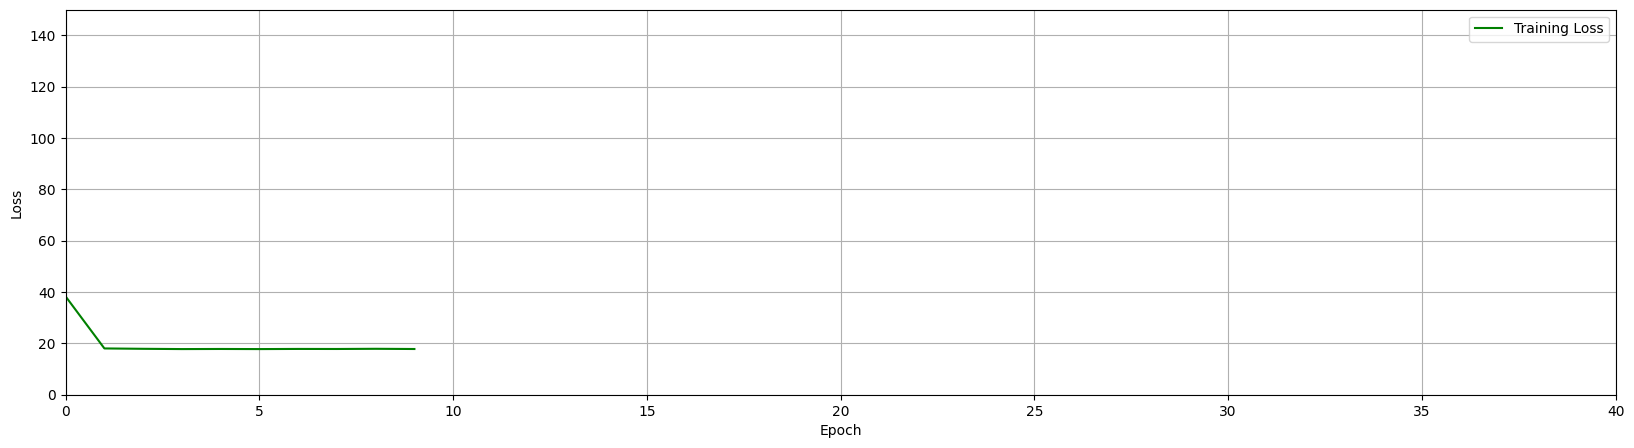

In [257]:
plot_loss(train)

/*------------- MODEL PREDICTION ------------------*/

In [258]:
testSetInput.shape

(21053, 8)

In [259]:
# Returns the Forecast Predictions
# data - the test data
# model - the training model used
# return - the prediction list
def forecast(data, model):
    
    predictions = model.predict(data)
    return predictions

In [260]:
# forecast(trainInputVal, regModel)

In [261]:
# Get No of steps to predict in the future
#forecastPeriod - No of hours to forecast
# samplingRate - The sampling rate of the data
# return - no of steps required for forecasting period
def stepCount(forecastPeriod, samplingRate):

    #Convert Hours to minutes
    forecast_minutes = forecastPeriod * 60

    steps = int(forecast_minutes / samplingRate);
    
    return steps

In [272]:

def forecastPrediction(data, windSpeedData, forecastPeriod, samplingRate):
    # Start Position - (ws-10, 30, 50, hub, p-1, p-2, p-3, p-4)
    startPos = data
    # lagVal = [None] *  4

    startData = {
        'P-1': startPos["P-1"],
        'P-2': startPos["P-2"],
        'P-3': startPos["P-3"],
        'P-4': startPos["P-4"]
        }
    
    startPos = pd.DataFrame(startData)
    
    # Wind information for timestamps - (ws-10, 30, 50, hub)
    windData = windSpeedData
    
    # No of Steps in future
    steps = stepCount(forecastPeriod, samplingRate)

    # list to store forecast
    forecastResult = []
    
    for i in range(steps):
    
        currentPos = concat([windData.iloc[[i]].reset_index(drop=True), startPos.reset_index(drop=True)], axis=1)
    
        pred = forecast(currentPos, regModel) #return - Power for currentPos

        # Assigning t lab to t-1 for older values
        startPos["P-4"] = startPos["P-3"]
        startPos["P-3"] = startPos["P-2"] 
        startPos["P-2"] = startPos["P-1"]
        startPos["P-1"] = pred[0][0]

        forecastResult.append(pred[0][0])
    
    return forecastResult

In [269]:
#The starting point with prev 4 Power Forecasts which exists
startPos = testSetInput.iloc[[0]] 
print(startPos.head())

# Wind speed forecast from different source can be considered
# There will be no power data for future forecasts so removing lags from test set
windSpeedData = testSetInput.drop(columns=['P-1', 'P-2', 'P-3', 'P-4']) 
windSpeedData.head()

# concat([windSpeedData, windSpeedData], axis=1)

                     WS_10  WS_30  WS_50  WS_hub        P-1       P-2  \
Timestamp                                                               
2020-05-26 16:45:00  8.125  8.343  8.564   8.688  25.439707  24.75543   

                           P-3        P-4  
Timestamp                                  
2020-05-26 16:45:00  14.561643  16.923567  


,WS_10,WS_30,WS_50,WS_hub
Timestamp,,,,
2020-05-26 16:45:00,8.125,8.343,8.564,8.688
2020-05-26 17:00:00,7.428,7.791,8.063,8.404
2020-05-26 17:15:00,6.360,6.522,7.057,7.468
2020-05-26 17:30:00,6.147,6.663,7.045,7.527
2020-05-26 17:45:00,7.389,8.032,8.689,8.602


In [270]:
# Get Forecast for the start datapoint and windspeeds for next timeperiods
predResult = forecastPrediction(startPos, windSpeedData, 6, 15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [283]:
# Plot graphs for actual output and prediction
def plotForecastGraph(inputVal, forecastPred):
    
    plt.plot(inputVal.index, inputVal, color='blue', label='Actual Power')
    plt.plot(inputVal.index, forecastPred, color='red', label='Prediction Power')
        
    plt.xlabel('Index')
    plt.ylabel('Output')
    plt.title('Actual vs. Predicted Power (MW)')
    
    plt.legend()
    plt.show()

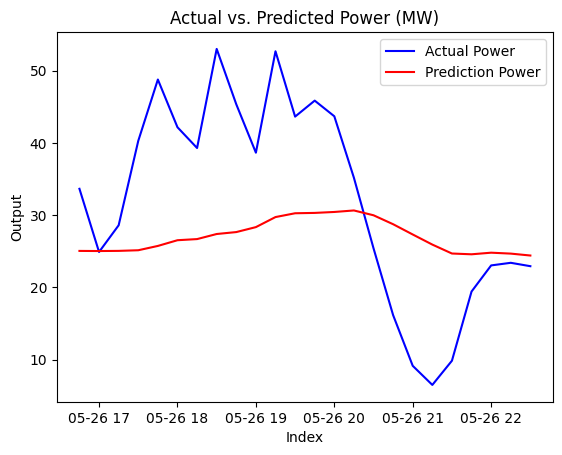

In [284]:
# # No of Steps
#     steps = stepCount(forecastPeriod, samplingRate)

plotForecastGraph(testSetOutput[:24], predResult)

# plotForecastGraph(testSetOutput[:24], predResult, None)

In [279]:
def error_metrics(actualData, predResult):
    mae = mean_absolute_error(actualData, predResult)
    mse = mean_squared_error(actualData, predResult)

    print("Mean Absolute Error(MAE) for the Dataset: ", mae)
    print("Mean Squared Error(MSE) for the Dataset: ", mse)

In [280]:
error_metrics(testSetOutput[:24], predResult)

Mean Absolute Error(MAE) for the Dataset:  11.716921996953326
Mean Squared Error(MSE) for the Dataset:  192.03699809743512
